<b><i>Show that rushing is less efficient than passing, both using yards per play and EPA per play. Also inspect the variability of these two play types

In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
#Import pbp data for 2016-2022 sesaon
seasons = range(2016, 2022 + 1)
pbp_py = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [48]:
#Create a new dataframe that filters on running and passing plays
pbp_run_pass = (pbp_py.query(
        '(play_type == "run" | play_type == "pass") & down.notnull()')
    .reset_index())

In [49]:
#Replace null rushing yards with a zero
pbp_run_pass.loc[pbp_run_pass.rushing_yards.isnull(), 'rushing_yards'] = 0

In [50]:
#Replace null passing yards with a zero
pbp_run_pass.loc[pbp_run_pass.passing_yards.isnull(), 'passing_yards'] = 0

In [58]:
#Change down to be an integer
pbp_run_pass['down'] = pbp_run_pass['down'].astype(str)

In [70]:
pbp_run_pass['total_yards'] = pbp_run_pass['passing_yards'] + pbp_run_pass['rushing_yards']

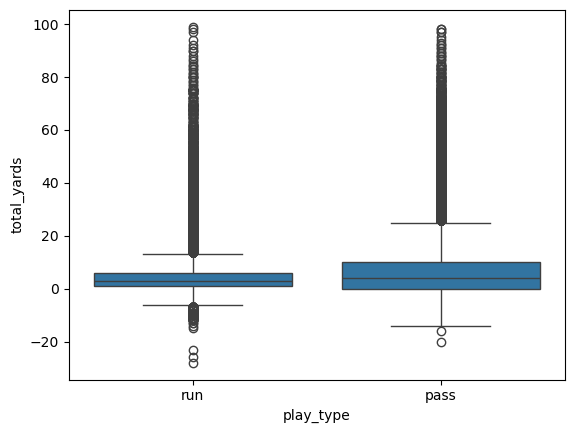

In [71]:
sns.boxplot(data=pbp_run_pass, x='play_type', y='total_yards');

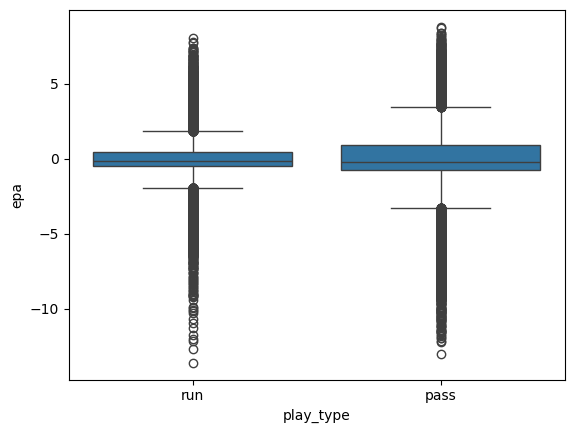

In [72]:
sns.boxplot(data=pbp_run_pass, x='play_type', y='epa');

<b>Regrouping Data

In [73]:
#Split into 2 dataframes (passing and rushing)
pbp_run = pbp_run_pass.loc[pbp_run_pass['play_type'] == 'run']
pbp_pass = pbp_run_pass.loc[pbp_run_pass['play_type'] == 'pass']

In [88]:
#Group rushing dataframe
rush_group = pbp_run.groupby(['season', 'rusher_id', 'rusher']).agg({'rushing_yards': ['count', 'sum', 'mean'], 'epa': ['mean']})

rush_group.columns = list(map('_'.join, rush_group.columns))

rush_group.reset_index(inplace=True)

In [90]:
#Change column names and filter out anyone with less than 51 attempts
rush_group = (rush_group.rename(columns={
            'rushing_yards_count': 'n', 
            'rushing_yards_sum': 'yards_total', 
            'rushing_yards_mean': 'ypc',
            'epa_mean': 'epa_per'})
        .query('n > 50'))

In [91]:
rush_group.sort_values(by='ypc', ascending=False)

,season,rusher_id,rusher,n,yards_total,ypc,epa_per
2228,2022,00-0034796,L.Jackson,73,571.0,7.821918,0.394800
1253,2019,00-0034796,L.Jackson,133,918.0,6.902256,0.223169
1281,2019,00-0035228,K.Murray,56,364.0,6.500000,0.063139
1891,2021,00-0034750,R.Penny,119,749.0,6.294118,0.094134
1554,2020,00-0034796,L.Jackson,121,758.0,6.264463,0.212720
...,...,...,...,...,...,...,...
1969,2021,00-0035860,T.Jones,54,142.0,2.629630,-0.346109
449,2017,00-0030485,E.Lacy,69,179.0,2.594203,-0.289167
2015,2021,00-0036414,C.Akers,72,175.0,2.430556,-0.459987
66,2016,00-0027791,J.Starks,63,145.0,2.301587,-0.356332


In [92]:
#Group passing dataframe
pass_group = pbp_pass.groupby(['season', 'passer_id', 'passer']).agg({'passing_yards': ['count', 'sum', 'mean'], 'epa': ['mean']})

pass_group.columns = list(map('_'.join, pass_group.columns))

pass_group.reset_index(inplace=True)

In [93]:
#Change column names and filter out anyone with less than 51 attempts
pass_group = (pass_group.rename(columns={
            'passing_yards_count': 'n', 
            'passing_yards_sum': 'yards_total', 
            'passing_yards_mean': 'ypa',
            'epa_mean': 'epa_per'})
        .query('n > 50'))

In [94]:
pass_group.sort_values(by='ypa', ascending=False)

,season,passer_id,passer,n,yards_total,ypa,epa_per
205,2018,00-0023682,R.Fitzpatrick,260,2366.0,9.100000,0.166258
22,2016,00-0026143,M.Ryan,676,5958.0,8.813609,0.332887
303,2019,00-0022787,M.Schaub,67,580.0,8.656716,0.316051
13,2016,00-0023645,D.Anderson,53,453.0,8.547170,-0.048294
158,2017,00-0031345,J.Garoppolo,184,1560.0,8.478261,0.313691
...,...,...,...,...,...,...,...
86,2016,00-0032893,C.Cook,71,311.0,4.380282,-0.489573
400,2019,00-0035251,W.Grier,58,228.0,3.931034,-0.485851
761,2022,00-0038128,M.Willis,71,276.0,3.887324,-0.547010
286,2018,00-0033958,N.Peterman,88,296.0,3.363636,-0.696688


<b>Stability Testing of Rushing

In [95]:
#Create rushing columns to keep
rush_cols_keep = ['season', 'rusher_id', 'rusher', 'ypc', 'epa_per']

In [97]:
#Create current year dataframe
rush_now_py = rush_group[rush_cols_keep].copy()

In [98]:
#Create last year dataframe
rush_last_py = rush_group[rush_cols_keep].copy()

In [100]:
rush_last_py.head()

,season,rusher_id,rusher,ypc,epa_per
11,2016,00-0023500,F.Gore,3.897338,-0.092811
12,2016,00-0023564,D.Sproles,4.659574,-0.028486
17,2016,00-0024242,D.Williams,3.324561,-0.097097
28,2016,00-0026153,J.Stewart,3.779817,-0.077250
31,2016,00-0026184,M.Forte,3.729358,-0.087056


In [101]:
#Rename columns on last year dataframe
rush_last_py.rename(columns={'ypc': 'ypc_last', 'epa_per': 'epa_per_last'}, inplace=True)

In [102]:
#Add 1 to season column in last year dataframe
rush_last_py['season'] += 1

In [103]:
#Merge current year and last year dataframe together
rush_lag_py = rush_now_py.merge(rush_last_py, how='inner', on=['rusher_id', 'rusher', 'season'])

In [104]:
#Examine the correlation for YPC
rush_lag_py[['ypc_last', 'ypc']].corr()

,ypc_last,ypc
ypc_last,1.000000,0.325996
ypc,0.325996,1.000000


In [106]:
#Examine the correlation for EPA
rush_lag_py[['epa_per_last', 'epa_per']].corr()

,epa_per_last,epa_per
epa_per_last,1.000000,0.287841
epa_per,0.287841,1.000000


<b>Stability Testing of Passing

In [107]:
#Create rushing columns to keep
pass_cols_keep = ['season', 'passer_id', 'passer', 'ypa', 'epa_per']

In [108]:
#Create current year dataframe
pass_now_py = pass_group[pass_cols_keep].copy()

In [109]:
#Create last year dataframe
pass_last_py = pass_group[pass_cols_keep].copy()

In [110]:
pass_last_py.head()

,season,passer_id,passer,ypa,epa_per
0,2016,00-0019596,T.Brady,7.870805,0.274486
1,2016,00-0020531,D.Brees,7.515152,0.148558
3,2016,00-0021206,J.McCown,6.043956,-0.144267
4,2016,00-0021429,C.Palmer,6.666142,0.034664
7,2016,00-0022803,E.Manning,6.505263,-0.044376


In [111]:
#Rename columns on last year dataframe
pass_last_py.rename(columns={'ypa': 'ypa_last', 'epa_per': 'epa_per_last'}, inplace=True)

In [112]:
#Add 1 to season column in last year dataframe
pass_last_py['season'] += 1

In [113]:
#Merge current year and last year dataframe together
pass_lag_py = pass_now_py.merge(pass_last_py, how='inner', on=['passer_id', 'passer', 'season'])

In [114]:
#Examine the correlation for YPA
pass_lag_py[['ypa_last', 'ypa']].corr()

,ypa_last,ypa
ypa_last,1.000000,0.427942
ypa,0.427942,1.000000


In [115]:
#Examine the correlation for EPA
pass_lag_py[['epa_per_last', 'epa_per']].corr()

,epa_per_last,epa_per
epa_per_last,1.000000,0.510954
epa_per,0.510954,1.000000
